In [1]:
import cv2 as cv
import os
import numpy as np
from tqdm import tqdm
from shutil import copy

In [2]:
dataset_path = r'../data/Paragraphs (PRImA Layout Analysis Dataset)/PRImA Layout Analysis Dataset'
dir_path_xml: str = '../data/Paragraphs (PRImA Layout Analysis Dataset)/PRImA Layout Analysis Dataset/XML'
dir_path_img: str = '../data/Paragraphs (PRImA Layout Analysis Dataset)/PRImA Layout Analysis Dataset/Images/'
dir_path_output: str = '../data/output'

In [3]:
all_path_list: list[str] = os.listdir(dir_path_xml)
all_path_list[:2]

['00000086.xml', '00000087.xml']

In [4]:
target_path_list: list[str] = all_path_list[22:23]

In [5]:
from xml.etree import ElementTree
from xml.etree.ElementTree import Element
import math

def get_text_region_list_from_xml(path: str) -> tuple[list[Element], str]:
    tree = ElementTree.parse(path)
    xmlns: str = tree.getroot().get('{http://www.w3.org/2001/XMLSchema-instance}schemaLocation').split()[0]
    page = tree.find(f'{{{xmlns}}}Page')
    return page.findall(f'{{{xmlns}}}TextRegion'), xmlns

def element_to_bbox(coords: Element, xmlns: str) -> tuple[int | None, int | None, int | None, int | None]:
    points: list[Element] = coords.findall(f'{{{xmlns}}}Point')
    if len(points) < 4:
        return None, None, None, None
    x0, y0, x1, y1 = math.inf, math.inf, -math.inf, -math.inf
    for p in points:
        x, y = int(p.get('x')), int(p.get('y'))
        if x < x0:
            x0 = x
        if x > x1:
            x1 = x
        if y < y0:
            y0 = y
        if y > y1:
            y1 = y

    return x0, y0, x1, y1

# Draw labels

In [24]:
color = (0, 0, 255)
thickness = 2
font = cv.FONT_HERSHEY_SIMPLEX
font_size = 0.5

for file_name_xml in tqdm(target_path_list):
    base_name = os.path.splitext(file_name_xml)[0]
    file_name_img = f'{base_name}.tif'
    file_path_xml = os.path.join(dir_path_xml, file_name_xml)
    file_path_img = os.path.join(dir_path_img, file_name_img)

    img: np.ndarray = cv.imread(file_path_img, 1)
    text_region_list, xmlns = get_text_region_list_from_xml(file_path_xml)
    for text_region in text_region_list:
        x0, y0, x1, y1 = element_to_bbox(text_region.find(f'{{{xmlns}}}Coords'), xmlns)
        if None in (x0, y0, x1, y1):
            continue
        cv.rectangle(img, (x0, y0), (x1, y1), color, thickness)

    cv.imwrite(os.path.join(dir_path_output, file_name_img), img)

100%|██████████| 1/1 [00:00<00:00,  4.00it/s]


In [6]:
from sklearn.model_selection import train_test_split

path_list_train, path_list_test = train_test_split(all_path_list, test_size=0.2, random_state=42)
len(path_list_train), len(path_list_test)

(382, 96)

# Create positives descriptors

In [31]:
with open('../data/Paragraphs (PRImA Layout Analysis Dataset)/PRImA Layout Analysis Dataset/info.dat', 'w+') as f:
    for file_name_xml in tqdm(path_list_train):
        file_path_xml: str = os.path.join(dir_path_xml, file_name_xml)

        base_name: str = os.path.splitext(file_name_xml)[0]
        if 'pc-' in base_name:
            base_name = base_name[3:]
        file_name_img: str = f'{base_name}.tif'
        file_path_img_source: str = os.path.join(dir_path_img, file_name_img)
        relative_file_path = os.path.join('.', 'positives', file_name_img)
        file_path_img_destination: str = os.path.join(dataset_path, relative_file_path)
        copy(file_path_img_source, file_path_img_destination)

        text_region_list, xmlns = get_text_region_list_from_xml(file_path_xml)
        bbox_list: list[tuple[int, int, int, int]] = []
        for idx, text_region in enumerate(text_region_list):
            x0, y0, x1, y1 = element_to_bbox(text_region.find(f'{{{xmlns}}}Coords'), xmlns)
            if None in (x0, y0, x1, y1):
                continue
            if x1 - x0 <= 0 or y1 - y0 <= 0:
                print(file_name_xml)
            bbox_list.append((x0, y0, x1 - x0, y1 - y0))

        bbox_descriptor: str = '  '.join([' '.join(map(str, cords)) for cords in bbox_list])
        f.write(f'{relative_file_path} {len(bbox_list)} {bbox_descriptor}\n')

100%|██████████| 382/382 [00:21<00:00, 17.77it/s]


# Copy negatives

In [7]:
def xml_name_to_img_name(name: str) -> str:
    base_name: str = os.path.splitext(name)[0]
    if 'pc-' in base_name:
        base_name = base_name[3:]
    file_name_img: str = f'{base_name}.tif'

    return file_name_img

negative_image_path_list: list[str] = [os.path.join('.', 'positives', xml_name_to_img_name(path)) for path in path_list_train]
negative_image_path_list[:2]

['.\\positives\\00000624.tif', '.\\positives\\00000398.tif']

In [23]:
with open('../data/Paragraphs (PRImA Layout Analysis Dataset)/PRImA Layout Analysis Dataset/bg.txt', 'w+') as f:
    for path in negative_image_path_list:
        f.write(f'{path}\n')

In [20]:
negative_image_names: list[str] = []
for file_name_xml in tqdm(path_list_train):
    file_path_xml: str = os.path.join(dir_path_xml, file_name_xml)
    base_name: str = os.path.splitext(file_name_xml)[0]
    if 'pc-' in base_name:
        base_name = base_name[3:]
    file_name_img: str = f'{base_name}.tif'
    negative_image_names.append(file_name_img)
    file_path_img_source: str = os.path.join(dir_path_img, file_name_img)
    relative_file_path: str = os.path.join('.', 'negatives', file_name_img)
    file_path_img_destination: str = os.path.join(dataset_path, relative_file_path)
    copy(file_path_img_source, file_path_img_destination)

 86%|████████▋ | 330/382 [00:17<00:02, 19.02it/s]


OSError: [Errno 28] No space left on device

# Evaluate

In [8]:
cascade = cv.CascadeClassifier()
if not cascade.load('../data/Paragraphs (PRImA Layout Analysis Dataset)/PRImA Layout Analysis Dataset/paragraph_classifier/cascade.xml'):
    print('--(!)Error loading face cascade')

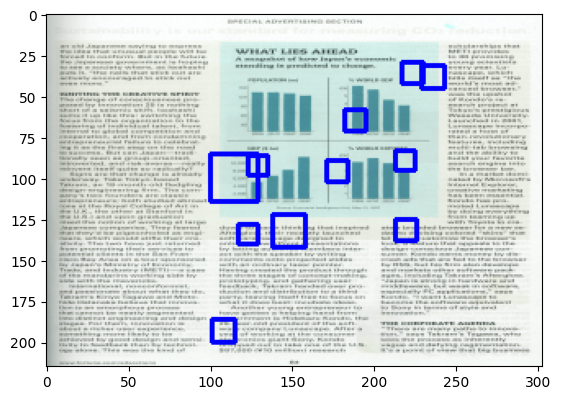

In [18]:
from matplotlib import pyplot as plt

def detect(xml_path: str) -> np.ndarray:
    test_img_path = os.path.join(dir_path_img, xml_name_to_img_name(xml_path))
    test_img = cv.imread(test_img_path)
    resized = cv.resize(test_img, (test_img.shape[0] // 10, test_img.shape[1] // 10), interpolation = cv.INTER_AREA)
    frame_gray = cv.cvtColor(resized, cv.COLOR_BGR2GRAY)
    frame_gray = cv.equalizeHist(frame_gray)

    faces = cascade.detectMultiScale(frame_gray)

    color = (0, 0, 255)
    thickness = 2
    for (x,y,w,h) in faces:
        center = (x + w//2, y + h//2)
        cv.rectangle(resized, center, (x + w, y + h), color, thickness)

    return resized


img_detected = detect(path_list_test[3])
plt.imshow(img_detected)
plt.show()